In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import glob
import re
import os

from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv("/Users/jeongjuhyeon/Desktop/Python/CS230/data/5_pap_NOhaptics_10.csv")

In [35]:
data_path_lst = pd.read_csv("/Users/jeongjuhyeon/Desktop/Python/CS230/data/Participant_6_results.csv")
data_path_lst

,Condition,Subcondition,Trial,Sensor1 Mean,Sensor2 Mean
0,PAP,HAPTICS,1,1132.18,1133.91
1,PAP,HAPTICS,2,1148.16,1148.12
2,PAP,HAPTICS,3,1125.18,1119.08
3,PAP,HAPTICS,4,1106.45,1106.37
4,PAP,HAPTICS,5,1161.47,1157.92
5,PAP,HAPTICS,6,1130.36,1129.46
6,PAP,HAPTICS,7,1197.76,1192.59
7,PAP,HAPTICS,8,1143.66,1187.48
8,PAP,HAPTICS,9,1149.43,1142.73
9,PAP,HAPTICS,10,1119.73,1121.87


In [75]:

all_files = glob.glob("data/*.csv")
datasets = {f: pd.read_csv(f) for f in all_files}


labels = []
examples = []
for fname, df in datasets.items():
    # .csv 확장자 제거
    base = os.path.basename(fname).replace(".csv", "")
    # print(f"file name: {base}")
    if len(base.split("_")) ==4:
        _, Condition, Subcondition,Trial  = base.split("_")
        if "pap" in Condition:
            Condition = Condition.replace("pap", "PAP")
        if "camera" in Condition:
            Condition = Condition.replace('camera', 'Camera')
        # print(Condition,Subcondition, Trial)
        row = data_path_lst[
        (data_path_lst["Condition"] == Condition)
        & (data_path_lst["Subcondition"] == Subcondition)
        & (data_path_lst["Trial"] == Trial)]
        
        if row.empty:
            print(f'no data {base}')
        
        else:
            if "Device 0 - Follower 0" in df.columns and "Device 0 - Follower 1" in df.columns:
                example = df[["Device 0 - Follower 0", "Device 0 - Follower 1"]].copy()
                label = row[["Sensor1 Mean", "Sensor2 Mean"]].values.flatten().tolist()
                examples.append(example)
                labels.append(label)

examples = [e.fillna(0) for e in examples]



print(f"Total #examples:  {len(examples)}.")  
print(len(examples), len(labels))
print(len(examples[0]))
print(len(examples[1]))
print(examples[0])
print(labels[0])


no data 3_training_NOhaptics_2
Total #examples:  40.
40 40
828
676
     Device 0 - Follower 0  Device 0 - Follower 1
0                     1124                   1119
1                     1124                   1118
2                     1124                   1118
3                     1123                   1118
4                     1124                   1118
..                     ...                    ...
823                   1017                    973
824                   1027                    977
825                   1015                    979
826                   1018                    972
827                    997                    970

[828 rows x 2 columns]
[1197.76, 1192.59]


In [83]:
# 각 example 별로 z-score 정규화 (각 센서별 평균=0, 표준편차=1)
scaler = StandardScaler()
tensor_examples = []
for e in examples:
    scaled = scaler.fit_transform(e.values)   # e는 (T_i, 2)
    tensor_examples.append(torch.tensor(scaled, dtype=torch.float32))

# label도 동일한 기준으로 스케일링
labels_arr = np.array(labels)
scaler_y = StandardScaler()
labels_scaled = scaler_y.fit_transform(labels_arr)
tensor_labels = torch.tensor(labels_scaled, dtype=torch.float32)

# ============================================================
# 2️⃣ Padding + Length 저장
# ============================================================
seq_lengths = torch.tensor([x.size(0) for x in tensor_examples])
padded_examples = pad_sequence(tensor_examples, batch_first=True, padding_value=0.0)
print(f"📏 padded_examples: {padded_examples.shape}, labels: {tensor_labels.shape}")


📏 padded_examples: torch.Size([40, 2166, 2]), labels: torch.Size([40, 2])


In [84]:
class PressureRNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2, num_layers=1):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        # pack: variable length 처리
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), 
                                                   batch_first=True, 
                                                   enforce_sorted=False)
        packed_out, (h_n, c_n) = self.rnn(packed)
        # 마지막 hidden state만 사용
        out = self.fc(h_n[-1])
        return out


In [88]:
model = PressureRNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 100
losses = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(padded_examples, seq_lengths)
    loss = criterion(outputs, tensor_labels)
    loss.backward()

    # gradient clipping (NaN 방지)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    losses.append(loss.item())

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}] | Loss: {loss.item():.6f}")



Epoch [5/100] | Loss: 0.980546
Epoch [10/100] | Loss: 0.955975
Epoch [15/100] | Loss: 0.926722
Epoch [20/100] | Loss: 0.890093
Epoch [25/100] | Loss: 0.847916
Epoch [30/100] | Loss: 0.799658
Epoch [35/100] | Loss: 0.734422
Epoch [40/100] | Loss: 0.656418
Epoch [45/100] | Loss: 0.582390
Epoch [50/100] | Loss: 0.522641
Epoch [55/100] | Loss: 0.456641
Epoch [60/100] | Loss: 0.445402
Epoch [65/100] | Loss: 0.400229
Epoch [70/100] | Loss: 0.412652
Epoch [75/100] | Loss: 0.610259
Epoch [80/100] | Loss: 0.357594
Epoch [85/100] | Loss: 0.506942
Epoch [90/100] | Loss: 0.385974
Epoch [95/100] | Loss: 0.334799
Epoch [100/100] | Loss: 0.521954


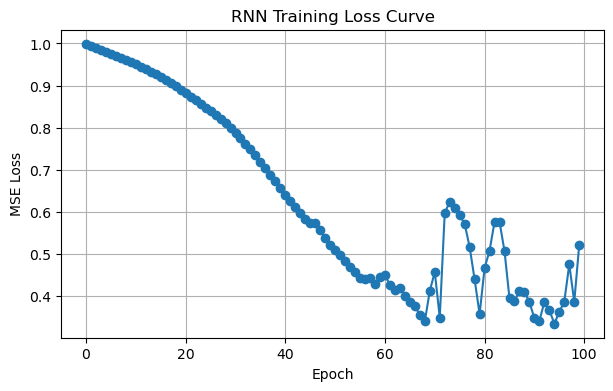

In [89]:
plt.figure(figsize=(7, 4))
plt.plot(losses, marker='o')
plt.title("RNN Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()